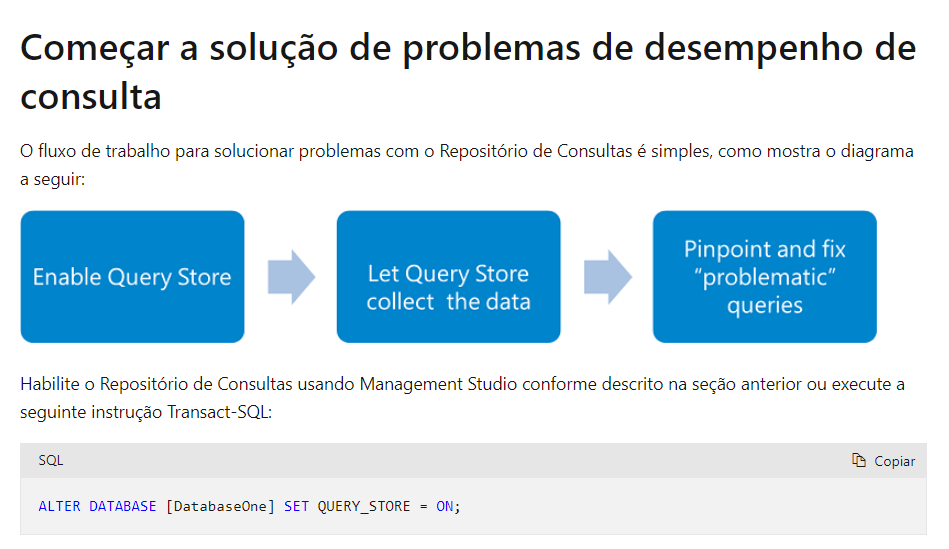

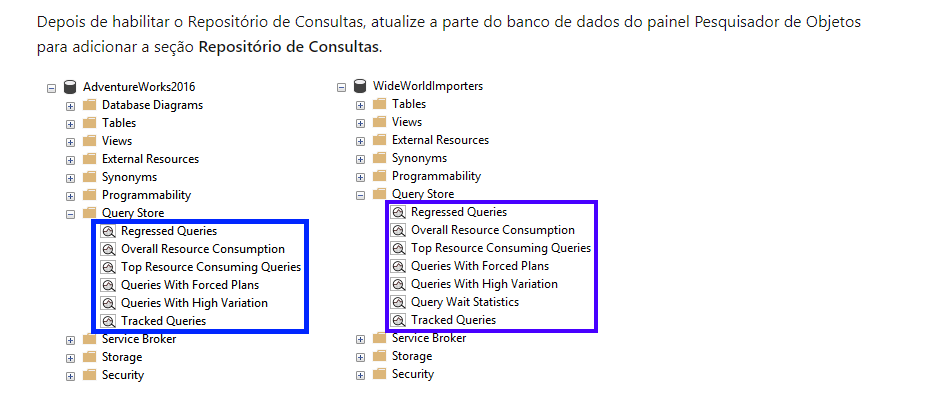

# **<mark>1) <span style="color: rgb(23, 23, 23); font-family: &quot;Segoe UI&quot;, SegoeUI, &quot;Helvetica Neue&quot;, Helvetica, Arial, sans-serif; font-size: clamp(1.59375rem, 18.7895px + 1.39803vw, 2.125rem);">Consultas Regredidas</span></mark>**

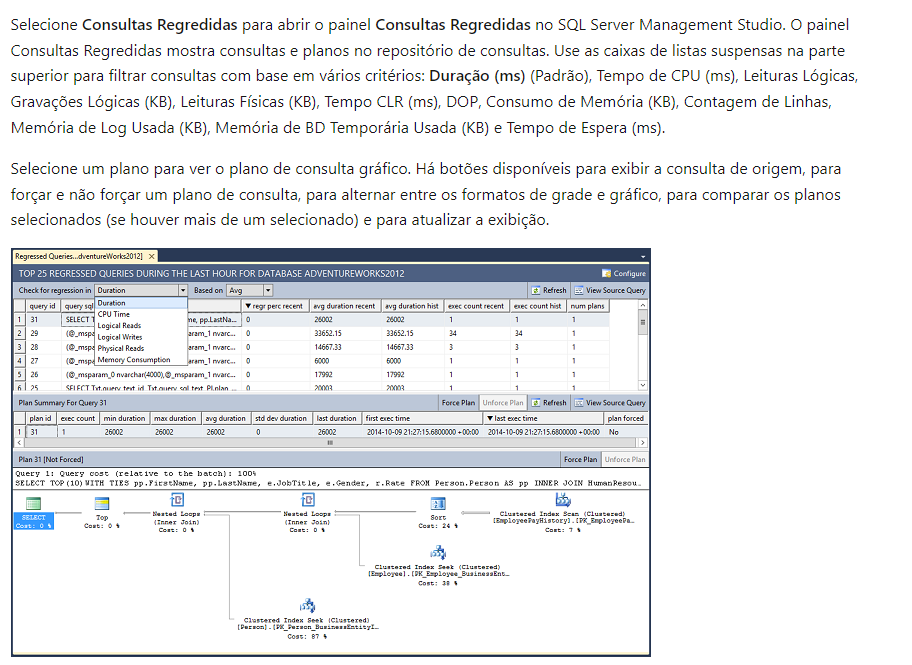

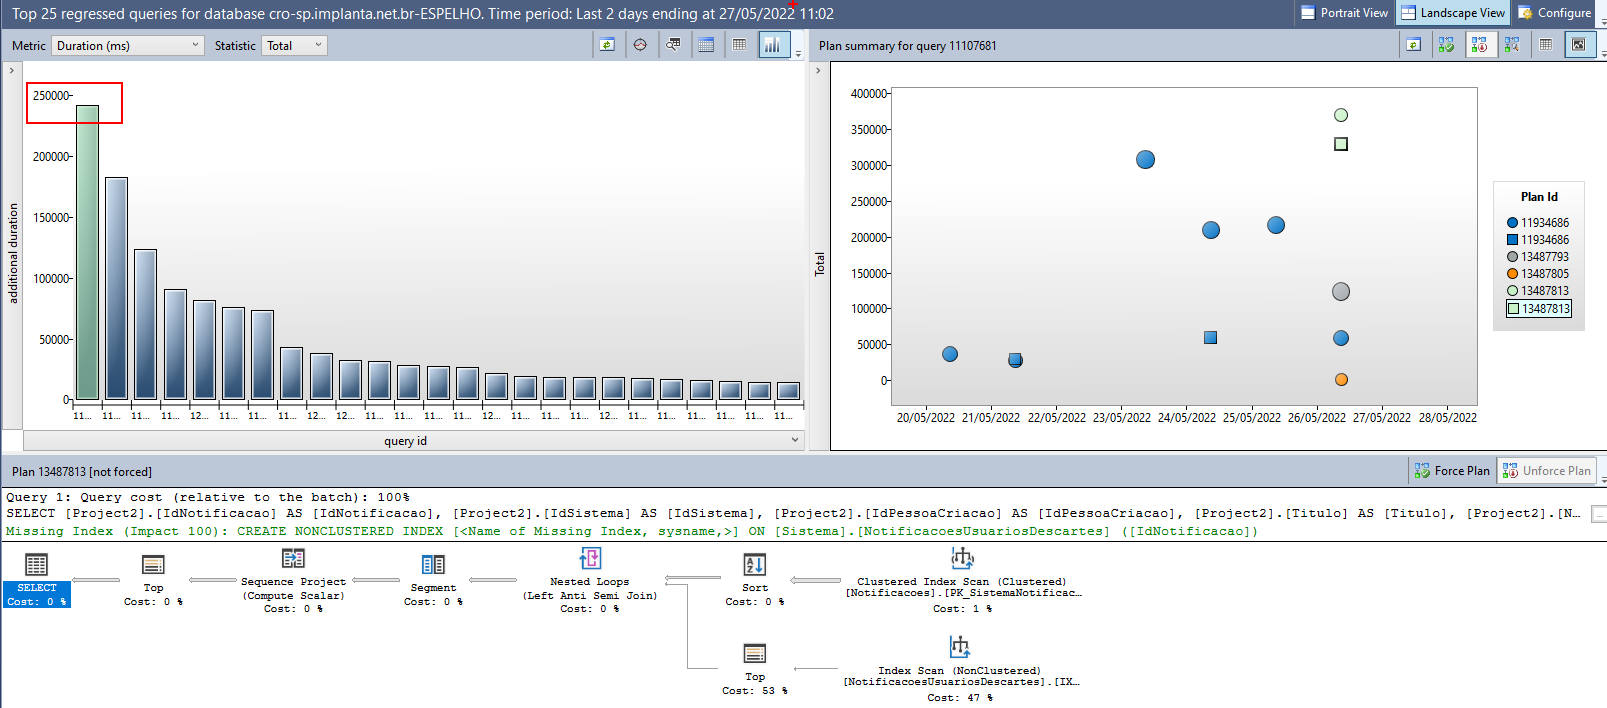

# **<mark>2) consultas em espera</mark>**

No SQL Server 2017 (14.x) e no Banco de Dados SQL do Azure em diante, as estatísticas de espera por consulta ao longo do tempo estão disponíveis no Repositório de Consultas.

No Repositório de Consultas, os tipos de espera são combinados em categorias de espera. O mapeamento das categorias de espera para tipos de espera está disponível em [sys.query\_store\_wait\_stats (Transact-SQL)](https://docs.microsoft.com/pt-br/sql/relational-databases/system-catalog-views/sys-query-store-wait-stats-transact-sql?view=sql-server-ver16#wait-categories-mapping-table).

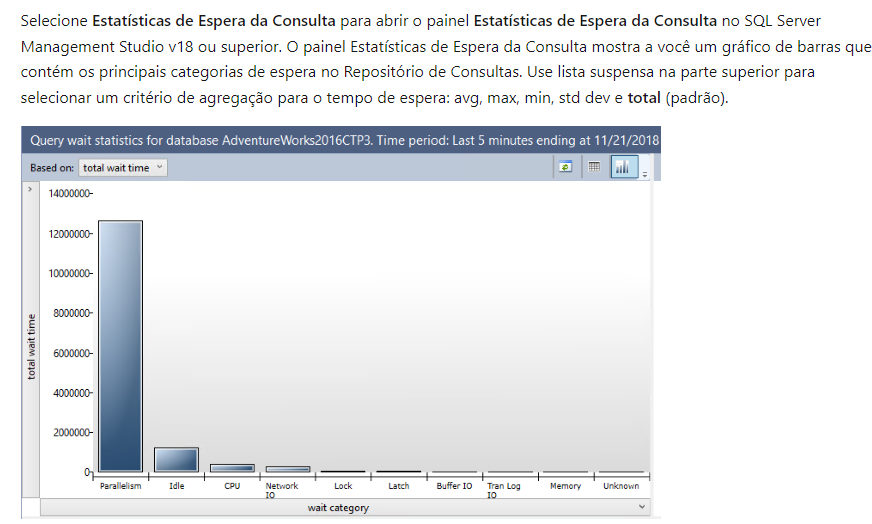

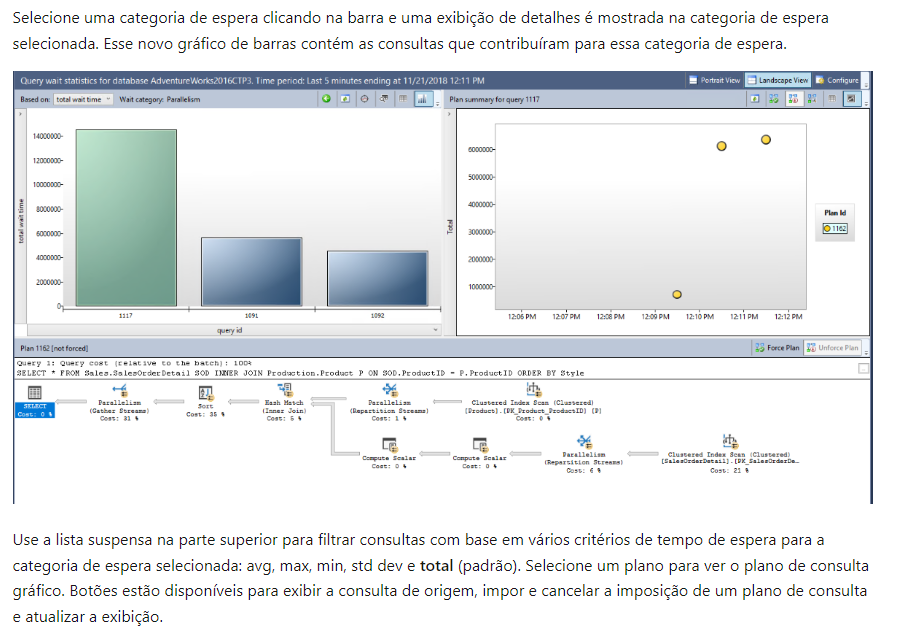

As categorias de espera combinam tipos diferentes de espera em buckets semelhantes por natureza. Categorias de espera diferentes exigem um acompanhamento de análise diferente para resolver o problema, mas tipos de espera de mesma categoria levam a experiências de solução de problemas muito semelhantes, e fornecer a consulta afetada com base nessas esperas seria a peça que faltava para concluir a maioria dessas investigações com êxito.

Aqui estão alguns exemplos de como você pode obter mais informações sobre sua carga de trabalho antes e depois de introduzir as categorias de espera no Repositório de Consultas:

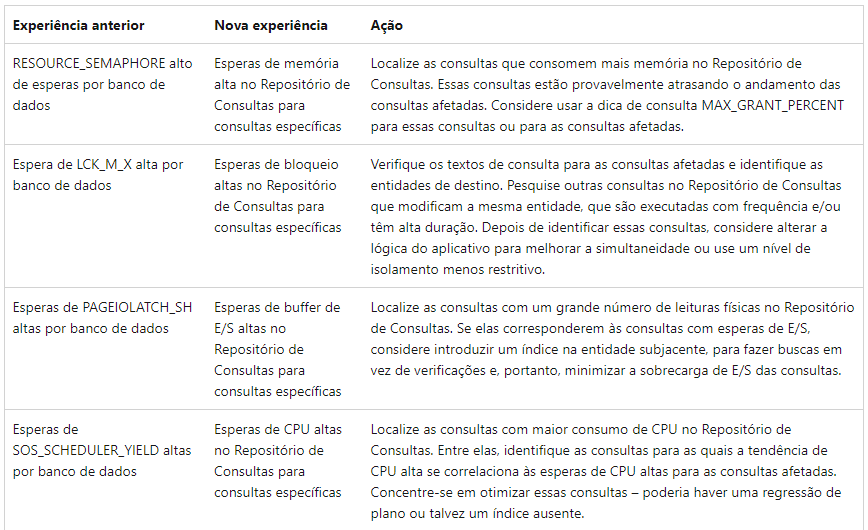

# **<mark>4)Track Querys</mark>**

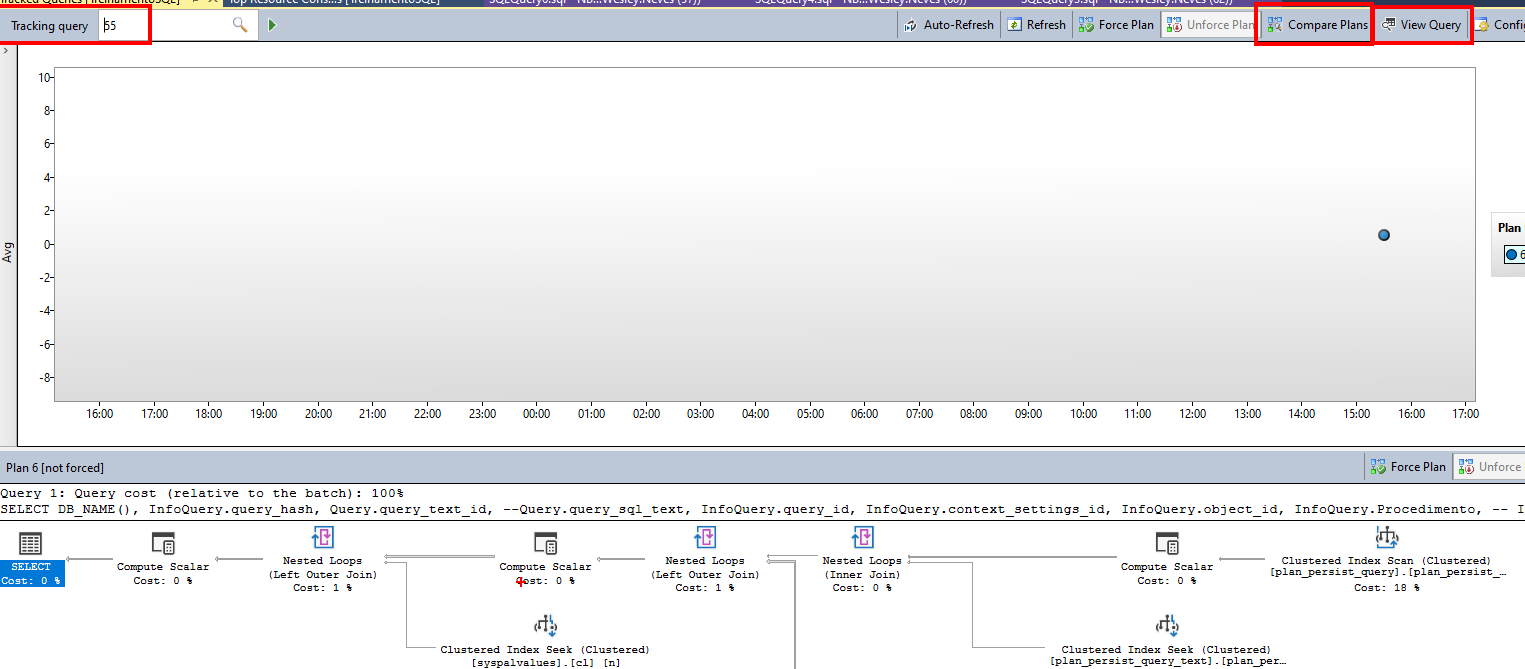

# **<mark>3) Excluir consultas ad hoc</mark>**

In [ ]:
SET NOCOUNT ON
-- This purges adhoc and internal queries from 
-- the Query Store in the current database 
-- so that the Query Store does not run out of space 
-- and remove queries we really need to track

DECLARE @id int;
DECLARE adhoc_queries_cursor CURSOR
FOR
    SELECT q.query_id
    FROM sys.query_store_query_text AS qt
    JOIN sys.query_store_query AS q
    ON q.query_text_id = qt.query_text_id
    JOIN sys.query_store_plan AS p
    ON p.query_id = q.query_id
    JOIN sys.query_store_runtime_stats AS rs
    ON rs.plan_id = p.plan_id
    WHERE q.is_internal_query = 1  -- is it an internal query then we dont care to keep track of it
       OR q.object_id = 0 -- if it does not have a valid object_id then it is an adhoc query and we don't care about keeping track of it
    GROUP BY q.query_id
    HAVING MAX(rs.last_execution_time) < DATEADD (minute, -5, GETUTCDATE())  -- if it has been more than 5 minutes since the adhoc query ran
    ORDER BY q.query_id;
OPEN adhoc_queries_cursor ;
FETCH NEXT FROM adhoc_queries_cursor INTO @id;
WHILE @@fetch_status = 0
BEGIN
    PRINT 'EXEC sp_query_store_remove_query ' + str(@id);
    EXEC sp_query_store_remove_query @id;
    FETCH NEXT FROM adhoc_queries_cursor INTO @id;
END
CLOSE adhoc_queries_cursor;
DEALLOCATE adhoc_queries_cursor;